# Home work 1 ML for bio
Amin Ravanbakhsh

96109725


In [460]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [461]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [462]:
class Data_Editor:

    def __init__(self):
        pass

    def shuffle(self, df):
        return df.sample(frac=1)

    def K_cross_fold(self, df, k):
        '''
            df: pd data frame
            k: count of folds
            return: split df to k parts
        '''
        n = len(df)
        k_fold = [None for i in range(k)]
        for i in range(k):
            k_fold[i] = df[int(i/k * n):int((i+1)/k*n)]

        return k_fold

    def split_train_val(self, df, val_rate):
        '''
            df: pd data frame
            split data to train and validation
            return train, val
        '''
        n = len(df)
        train_size = n - int(n * val_rate)
        return df[:train_size], df[train_size:]

    def train_val_k_fold(self, df, k):
        '''
            df: pd data frame
            k: count of folds
            return train_set, val_set
        '''

        val_set = []
        train_set = []
        n = len(df)
        
        for i in range(k):
            val_set.append(df[int(i/k * n):int((i+1)/k*n)])
            train_set.append(pd.concat([df[:int(i/k * n)], df[int((i+1)/k*n):]]))

        return train_set, val_set

In [463]:
class Evaluation:

    def __init__(self, predict, target):
        self.predict = np.array(predict)
        self.target = np.array(target)

    def calc(self):
        correct = np.logical_xor(self.predict, self.target)
        self.N = len(self.target)
        self.TP = list(np.logical_and(correct, self.target)).count(True)
        self.TN = list(np.logical_and(correct, np.logical_not(self.target))).count(True)
        self.FP = list(np.logical_and(np.logical_not(correct), self.target)).count(True)
        self.FN = list(np.logical_and(np.logical_not(correct), np.logical_not(self.target))).count(True)

    def accuracy(self):
        return (self.TP + self.TN) / self.N

    def precision(self):
        return self.TP/(self.TP + self.FP)

    def recall(self):
        return self.TP/(self.TP + self.FN)

    def sensitivity(self):
        return self.TP/(self.TP + self.FN)
    
    def specificity(self):
        return self.TN/(self.TN + self.FP)

    def f_score(self):
        return 2 / ((1/self.precision()) + (1/ self.recall()))


# section 1
Decision Tree


import data from google drive

In [464]:
train_df = pd.read_csv('/content/drive/MyDrive/ML_for_BIO/hws/hw1/Diabetes/Train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/ML_for_BIO/hws/hw1/Diabetes/Test.csv')

In [465]:
train_df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,164,82,43,67,32.8,0.341,50,False
1,4,90,0,0,0,28.0,0.610,31,False
2,1,138,82,0,0,40.1,0.236,28,False
3,4,110,92,0,0,37.6,0.191,30,False
4,2,93,64,32,160,38.0,0.674,23,True
5,1,101,50,15,36,24.2,0.526,26,False
6,2,112,75,32,0,35.7,0.148,21,False
7,0,67,76,0,0,45.3,0.194,46,False
8,0,104,76,0,0,18.4,0.582,27,False
9,4,110,76,20,100,28.4,0.118,27,False


In [466]:
class Decision_Tree_Classifier:

    def __init__(self, X, y, max_depth):
        '''
            X: pd.dataframe
            y: target(boolean) pd.series
            max_depth: max depth of tree
            tree: decision tree
        '''
        self.X = X
        self.y = y
        self.max_depth = max_depth
        self.tree = None

    def split_data(self, X, y, feature_name):
        '''
            X: dataframe
            y: target(boolean)
            feature_name: feature to split
            return: x_true, y_true, x_false, y_false
        '''
        feature_true_index = X[feature_name] == True
        feature_false_index = X[feature_name] == False
        return X[feature_true_index], y[feature_true_index], X[feature_false_index], y[feature_false_index]

    def entropy(self, X, Y):
        '''
            X: dataframe
            y: target(boolean)
        '''
        y = list(np.array(Y))
        size = y.count(True)
        n = len(y)
        p = size / n
        
        if p == 0 or p == n or p == 1:
            return 0

        return - p * np.log2(p) - (1-p) * np.log2(1-p)
      

    def information_gain(self, X, y, feature_name):
        '''
            X: dataframe
            y: target(boolean)
            feature_name: feature for information gain
            return: information gain
        '''

        xt, yt, xf, yf = self.split_data(X, y, feature_name)

        nt = len(yt)
        nf = len(yf)
        n = len(y)

        if nt == 0 or nf == 0:
            return 0

        return self.entropy(X,y) - nt/n * self.entropy(xt, yt) - nf/n * self.entropy(xf, yf)

    
    def best_information_gain_feature(self, X, y):
        '''
            X: dataframe
            y: target(boolean)
            return: best_feature, information_gain(best_feature)
        '''
        features = list(X.columns)
        best_feature = None
        max_info_gain = 0
        for f in features:
            info_gain = self.information_gain(X, y, f)
            if info_gain > max_info_gain:
                best_feature = f
                max_info_gain = info_gain

        return best_feature, max_info_gain

    def fit_node(self, node, depth):
        '''
            node: node of data and information about feature of data set
            depth: depth of node
            return: set tree
        '''
        
        if node.is_all_same(): 
            node.feature_name = None
            node.predict = node.y.iloc[0]
        
        elif depth >= self.max_depth:
            node.feature_name = None
            node.predict = node.get_predict()

        else:
            best_feature, max_info_gain = self.best_information_gain_feature(node.X, node.y)
            node.feature_name = best_feature
            node.information_gain = max_info_gain
        
            if best_feature != None:
                Xt, yt, Xf, yf = self.split_data(node.X, node.y, best_feature)
                node.true_node = Node(Xt, yt)
                node.false_node = Node(Xf, yf) 
                self.fit_node(node.true_node, depth+1)
                self.fit_node(node.false_node, depth+1)
            else:
                node.predict = node.get_predict()
        
    def fit(self):
        '''
            make decision tree
        '''
        root = Node(self.X, self.y)
        self.fit_node(root, 0)
        self.tree = root

    def predict_row(self, X, row_index):
        '''
            X: pd DataFrame for predict
            row_index: int
        '''
        tree = self.tree
        while tree.feature_name:
            if X.iloc[row_index][tree.feature_name]:
                tree = tree.true_node
            else:
                tree = tree.false_node

        return tree.predict

    def predict(self, X):
        '''
            X: pd DataFrame
        '''
        predict = []
        for i in range(len(X)):
            predict.append(self.predict_row(X,i))

        return np.array(predict)

    def accuracy(self, X, y):
        predict = self.predict(X).astype(int)
        np_y = np.array(y).astype(int)
        return 1 - np.sum(np.abs(predict - np_y))/len(y)

    def print_node(self, node, depth, word):
        if node.feature_name != None:
            print('   ' * depth, depth, word, node.feature_name, node.information_gain,node.predict)
            if node.true_node != None:
                self.print_node(node.true_node, depth + 1, 'True')
            if node.false_node != None:
                self.print_node(node.false_node, depth + 1, 'False')


    def print_tree(self):
        self.print_node(self.tree, 1, '')

In [467]:
class Node:

    def __init__(self, X, y):
        '''
            X: pd DataFrame
            y: pd Series
            
        '''
        self.X = X
        self.y = y
        self.true_node = None
        self.false_node = None
        self.feature_name = None
        self.information_gain = None
        self.predict = None

    def is_all_same(self):
        z = np.array(self.y)
        return np.all(z == z[0])
    
    def get_predict(self):
        z = list(self.y)
        if z.count(True) >= z.count(False):
            return True
        else:
            return False


In [468]:
def true_flase_df(df, threshold):
    '''
        true if val > threshold else false
        df: pd DataFrame
        return: true_false_df as X, outcome as y
    '''

    y = df['Outcome']
    t_df = df.drop(columns = ['Outcome'])
    columns = t_df.columns

    for col in columns:
        t_df[col] = (t_df[col] > threshold[col])

    return t_df, y

def plot_feature(df):
    '''
        plot outcome and features
    '''
    features = list(df.drop(columns = ['Outcome']).columns)
    for f in features:
        sns.set_theme()
        sns.relplot(df[f], df['Outcome'])

Outcome and features plot

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

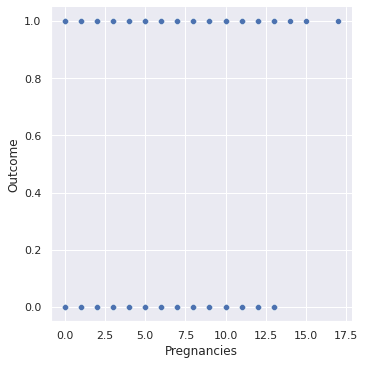

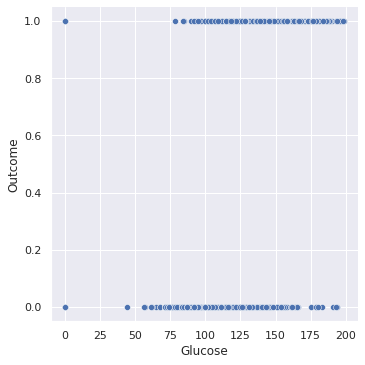

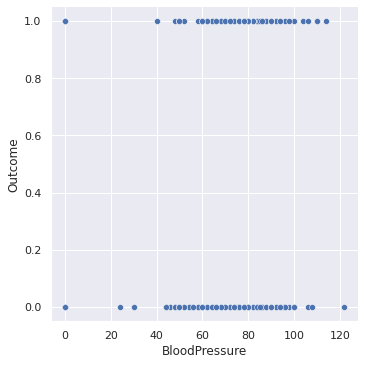

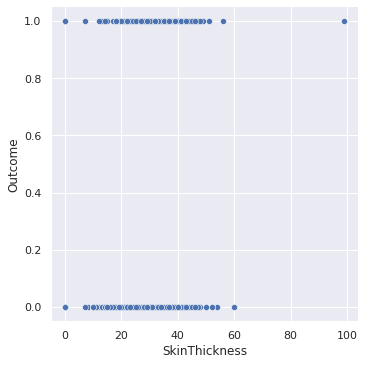

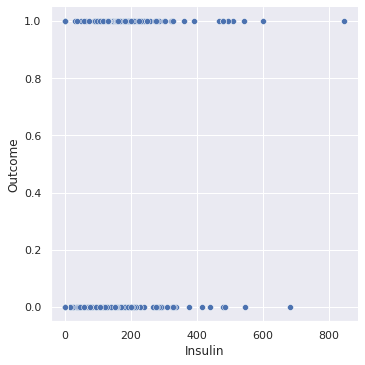

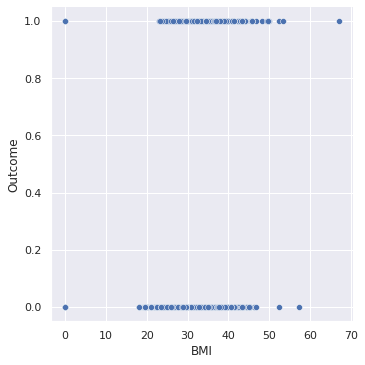

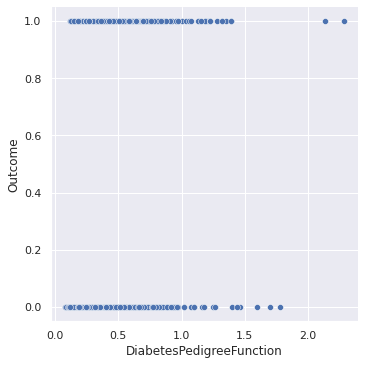

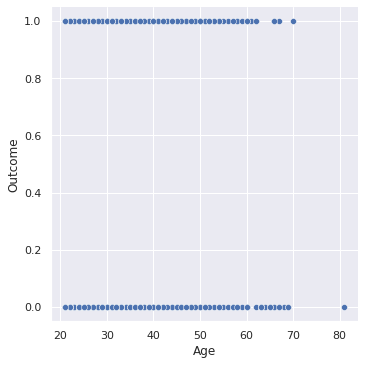

In [469]:
plot_feature(train_df)

map dataframe to true and false data frame by data mean

In [470]:
train_describe = train_df.describe()
X_train, y_train = true_flase_df(train_df, train_describe.T['mean'])
X_test, y_test = true_flase_df(test_df, train_describe.T['mean'])

train decision tree on data

In [471]:
DTC = Decision_Tree_Classifier(X_train,y_train,8)
DTC.fit()

train decision tree with depth between 1 - 8

test tree on train_df and test_df

plot accuracy of test and train

In [472]:
train_accuracy = []
test_accuracy = []

In [473]:
for depth in range(1, 9):
    DTC = Decision_Tree_Classifier(X_train,y_train,depth)
    DTC.fit()
    train_accuracy.append(DTC.accuracy(X_train, y_train))
    test_accuracy.append(DTC.accuracy(X_test, y_test))

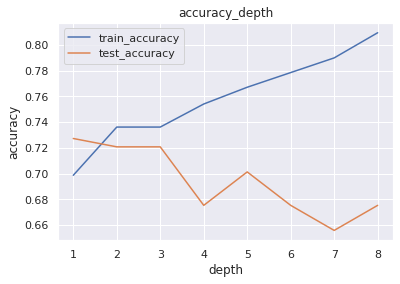

In [474]:
depths = range(1,9)
plt.plot(depths, train_accuracy, label = 'train_accuracy')
plt.plot(depths, test_accuracy, label = 'test_accuracy')
plt.xlabel('depth')
plt.ylabel('accuracy')
plt.title('accuracy_depth')
plt.legend()
plt.show()

cross validation

In [475]:
DE = Data_Editor()
train_shuffle_df = DE.shuffle(train_df)
fold_count = 5
train_set, val_set = DE.train_val_k_fold(train_shuffle_df, fold_count)

train_cross_validation_accuracy = []
val_cross_validation_accuracy = []

In [476]:
for depth in range(1,9):
    train_total_accuracy = 0
    val_total_accuracy = 0
    for i in range(fold_count):
        train_cross_describe = train_set[i].describe()
        X_train_cross, y_train_cross = true_flase_df(train_set[i], train_cross_describe.T['mean'])
        X_val_cross, y_val_cross = true_flase_df(val_set[i], train_cross_describe.T['mean'])
        DTC = Decision_Tree_Classifier(X_train_cross, y_train_cross, depth)
        DTC.fit()
        train_total_accuracy += DTC.accuracy(X_train_cross, y_train_cross)
        val_total_accuracy += DTC.accuracy(X_val_cross, y_val_cross)

    train_cross_validation_accuracy.append(train_total_accuracy/fold_count)
    val_cross_validation_accuracy.append(val_total_accuracy/fold_count)

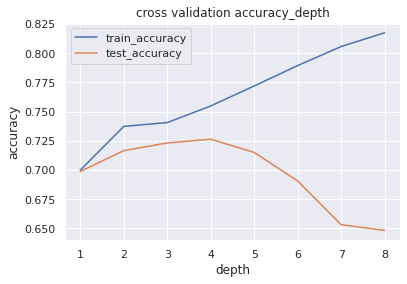

In [477]:
depths = range(1,9)
plt.plot(depths, train_cross_validation_accuracy, label = 'train_accuracy')
plt.plot(depths, val_cross_validation_accuracy, label = 'test_accuracy')
plt.xlabel('depth')
plt.ylabel('accuracy')
plt.title('cross validation accuracy_depth')
plt.legend()
plt.show()

select best depth

In [478]:
depth_best = 4

In [485]:
DTC = Decision_Tree_Classifier(X_train, y_train, depth_best)
DTC.fit()

In [486]:
predict = DTC.predict(X_test)
target = y_test
eval = Evaluation(predict, target)
eval.calc()
print('accuracy: ', eval.accuracy())
print('f_score: ', eval.f_score())
print('sensitivity: ', eval.sensitivity())
print('specificity: ', eval.specificity())

accuracy:  0.2792207792207792
f_score:  0.3190184049079754
sensitivity:  0.23853211009174313
specificity:  0.37777777777777777


<p dir = rtl>
    زمانی که داده‌ها به صورت ناهمگن هستند استفاده از توابع ذکر شده دقیق تر از accuracy می باشد. 
<p>

<p dir = rtl>
    f_score در واقع یک میانگین بین مقدار recall و percision است.
<p>

<p dir = rtl>
    از دوتابع دیگر هم زمانی استفاده می‌کنیم که می خواهیم دقت را روی مجموعه ای که به عنوان درست معرفی شده‌اند استفاده کنیم و تمرکز خود را بر روی داده‌هایی که درست تخمین زده شده‌اند بگذاریم
<p>

# section 1
perceptron


In [283]:
train_df = pd.read_csv('/content/drive/MyDrive/ML_for_BIO/hws/hw1/Diabetes/Train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/ML_for_BIO/hws/hw1/Diabetes/Test.csv')

In [284]:
def clean_data(df):
    '''
        df: pd data frame
        remove zero values rows and reset_index 
    '''
    t_df = df[(df['BMI'] != 0) & (df['Glucose'] != 0) & (df['BloodPressure'] != 0)]
    t_df = t_df.reset_index(drop = True)
    y = t_df['Outcome'].astype(int) * 2 - 1
    X = t_df.drop(columns = ['Outcome'])
    return X, y

def normalize(X):
    '''
        put datas between -1 and 1
    '''
    xp = pd.DataFrame()
    features = X.columns
    for f in features:
        xp[f] = -1 + 2 * (X[f] - X[f].min()) / (X[f].max() - X[f].min())

    return xp


In [432]:
class Perceptron_Classifier:

    def __init__(self, X_train, y_train, X_val, y_val):
        '''
            X_train: pd data frame
            y_train: pd series
            X_test: pd data frame
            y_test: pd series
            w: random values between -1 and 1
            b: 0
        '''

        self.shape = X_train.shape
        self.X = X_train.to_numpy()
        self.y = y_train.to_numpy().reshape((self.shape[0], 1))

        self.X_val = X_val.to_numpy()
        self.y_val = y_val.to_numpy().reshape((len(y_val), 1))

        self.w = np.random.uniform(-1,1,(self.shape[1], 1))
        self.b = 0

    def activation(self, val):
        return  1 if val >= 0 else -1
        
    def activation_arr(self, y):
        a = np.array((y >= 0).astype(int))
        return 2*a - 1

    def prediction(self, x):
        np_x = np.array(x).reshape((1, self.shape[1]))
        return self.activation(np.dot(np_x, self.w) + self.b)

    def prediction_arr(self, X):
        np_X = np.array(X).reshape((X.shape[0], self.shape[1]))
        return self.activation_arr(np.dot(np_X, self.w) + self.b)

    def error(self, prediction, y):
        y_np = np.array(y).reshape((len(y), 1))
        return 0.5 * np.sum(np.abs(prediction - y_np))

    def get_loss(self, X, y):
        '''
            X: pd dataframe
            y: target
        '''
        return self.error(self.prediction_arr(X), y)

    def get_prediction_arr_by_w(self, X, w, b):
        np_X = np.array(X).reshape((X.shape[0], self.shape[1]))
        return self.activation_arr(np.dot(np_X, w) + b)

    def get_loss_by_w(self, X, y, w, b):
        return self.error(self.get_prediction_arr_by_w(X,w,b), y)

    def get_true_false_predict(self, predict):
        p = np.array(predict).reshape((len(predict), ))
        return p == 1

    def show_vectors(self):
        print('w:', self.w)
        print('b:', self.b)

    def fit(self, epochs, lr=1):
        shape = self.shape
        X = self.X
        y = self.y
        X_val = self.X_val
        y_val = self.y_val

        self.w = np.random.uniform(-1,1,(shape[1], 1))
        self.b = 0

        ws = []
        bs = []
        losses = []
        for _ in range(epochs):
            for i in range(shape[0]):
                e = 0.5 * (y[i] - self.prediction(X[i]))
                self.w += lr * e * X[i].reshape((shape[1],1))
                self.b += lr * e

                ws.append(self.w)
                bs.append(self.b)
                losses.append(self.get_loss(X_val, y_val))

        return losses, ws, bs
        

    def full_batch(self, epochs, lr = 1):
        shape = self.shape
        X = self.X
        y = self.y
        X_val = self.X_val
        y_val = self.y_val

        ws = []
        bs = []
        losses = []
        self.w = np.random.uniform(-1,1,(shape[1], 1))
        self.b = 0

        for _ in range(epochs):
            e = y - self.prediction_arr(X)
            dw = np.dot(X.T, e)
            self.w += lr * dw.reshape((shape[1], 1))
            db = np.sum(e)
            self.b += lr * db

            ws.append(self.w)
            bs.append(self.b)
            losses.append(self.get_loss(X_val, y_val))

        return losses, ws, bs

    def mini_batch(self, batch_count, epochs, lr = 1):
        shape = self.shape
        X = self.X
        y = self.y
        X_val = self.X_val
        y_val = self.y_val

        self.w = np.random.uniform(-1,1,(shape[1], 1))
        self.b = 0

        k = shape[0]/batch_count
        batchs_X = []
        batchs_y = []
        for j in range(batch_count):
            batchs_X.append(X[int(j*k):int((j+1)*k)])
            batchs_y.append(y[int(j*k):int((j+1)*k)])
        
        ws = []
        bs = []
        losses = []
        for _ in range(epochs):
            for j in range(batch_count):
                Xb = batchs_X[j]
                yb = batchs_y[j]

                e = yb - self.prediction_arr(Xb)
                dw = np.dot(Xb.T, e)
                self.w += lr * dw.reshape((shape[1], 1))
                db = np.sum(e)
                self.b += lr * db

                ws.append(self.w)
                bs.append(self.b)
                losses.append(self.get_loss(X_val, y_val))

        return losses, ws, bs
    

        

clean and normalize data

In [292]:
X_train, y_train = clean_data(train_df)
X_train = normalize(X_train)

In [321]:
X_test, y_test = clean_data(test_df)
X_test = normalize(X_test)

run perceptron

In [362]:
pc = Perceptron_Classifier(X_train,y_train,X_train, y_train)
losses, ws, bs = pc.fit(5, 0.001)

loss:  165.0


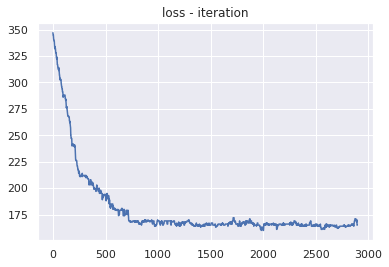

In [369]:
plt.plot(range(len(losses)), losses)
plt.title('loss - iteration')
plt.show()

cross validation

In [364]:
DE = Data_Editor()
t_df, v_df = DE.split_train_val(train_df, 0.15)

In [366]:
X_t, y_t = clean_data(t_df)
X_t = normalize(X_t)

In [365]:
X_v, y_v = clean_data(v_df)
X_v = normalize(X_v)

normal perceptron

In [421]:
pc = Perceptron_Classifier(X_t,y_t,X_v, y_v)
losses, ws, bs = pc.fit(5, 0.001)

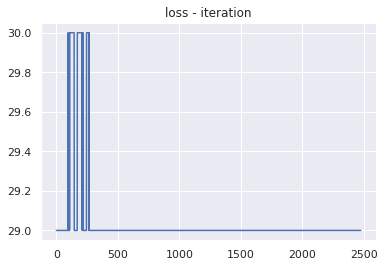

In [422]:
plt.plot(range(1, len(losses)+1), losses)
plt.title('loss - iteration')
plt.show()

choose best w and calcualte loss on test
choose the best by plot

In [423]:
w_best = ws[2200]
b_best = bs[2200]

In [431]:
print('loss:', pc.get_loss_by_w(X_test, y_test, w_best, b_best))

predict = pc.get_prediction_arr_by_w(X_test, w_best, b_best)
predict = pc.get_true_false_predict(predict)

target = pc.get_true_false_predict(y_test)

eval = Evaluation(predict, target)
eval.calc()
print('accuracy: ', eval.accuracy())
print('f_score: ', eval.f_score())
print('sensitivity: ', eval.sensitivity())
print('specificity: ', eval.specificity())

loss: 52.0
accuracy:  0.3586206896551724
f_score:  0.24390243902439027
sensitivity:  0.20833333333333334
specificity:  0.5068493150684932


full batch

In [446]:
pc = Perceptron_Classifier(X_t,y_t,X_v, y_v)
losses, ws, bs = pc.full_batch(20, 0.001)

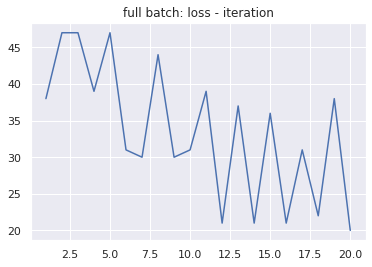

In [447]:
plt.plot(range(1, len(losses)+1), losses)
plt.title('full batch: loss - iteration')
plt.show()

In [448]:
w_best = ws[13]
b_best = bs[13]

In [449]:
print('loss:', pc.get_loss_by_w(X_test, y_test, w_best, b_best))

predict = pc.get_prediction_arr_by_w(X_test, w_best, b_best)
predict = pc.get_true_false_predict(predict)

target = pc.get_true_false_predict(y_test)

eval = Evaluation(predict, target)
eval.calc()
print('accuracy: ', eval.accuracy())
print('f_score: ', eval.f_score())
print('sensitivity: ', eval.sensitivity())
print('specificity: ', eval.specificity())

loss: 49.0
accuracy:  0.33793103448275863
f_score:  0.49473684210526325
sensitivity:  0.3381294964028777
specificity:  0.3333333333333333


mini batch

In [455]:
pc = Perceptron_Classifier(X_t,y_t,X_v, y_v)
losses, ws, bs = pc.mini_batch(10, 20, 0.001)

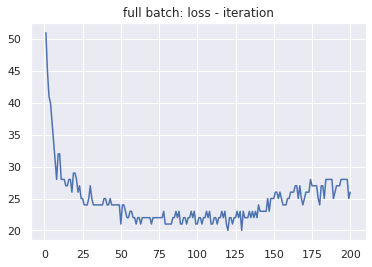

In [456]:
plt.plot(range(1, len(losses)+1), losses)
plt.title('full batch: loss - iteration')
plt.show()

In [457]:
w_best = ws[100]
b_best = bs[100]

In [458]:
print('loss:', pc.get_loss_by_w(X_test, y_test, w_best, b_best))

predict = pc.get_prediction_arr_by_w(X_test, w_best, b_best)
predict = pc.get_true_false_predict(predict)

target = pc.get_true_false_predict(y_test)

eval = Evaluation(predict, target)
eval.calc()
print('accuracy: ', eval.accuracy())
print('f_score: ', eval.f_score())
print('sensitivity: ', eval.sensitivity())
print('specificity: ', eval.specificity())

loss: 39.0
accuracy:  0.2689655172413793
f_score:  0.3614457831325301
sensitivity:  0.2608695652173913
specificity:  0.3


# section 2
regression

load data from google drive

In [52]:
train_df = pd.read_csv('/content/drive/MyDrive/ML_for_BIO/hws/hw1/regression/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/ML_for_BIO/hws/hw1/regression/test.csv')

In [53]:
train_df.head(10)

,age,gender,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [127]:
def preprocess_data(df):
    '''
        gender: one hot 
        smoker: true_false -> one_zero
        region: one hot
        basis: age^2
        one: add constant 1
    '''
    p_df = None

    #gender
    gender_df = pd.get_dummies(df['gender'])
    p_df = pd.concat([df, gender_df], axis = 1, join='inner')
    p_df = p_df.drop(columns=['gender'])
    
    #smoker
    p_df['smoker'] = (p_df['smoker'] == 'yes').astype(int)

    #region
    region_df = pd.get_dummies(p_df['region'])
    p_df = pd.concat([p_df, region_df], axis=1, join='inner')
    p_df = p_df.drop(columns=['region'])

    #basis
    p_df['basis'] = p_df['age']**2

    #one
    p_df['one'] = 1

    return p_df

def split_x_y(df):
    '''
        df: pd data frame
        return: x, y
    '''
    y = df['charges']
    x = df.drop(columns=['charges'])
    return x, y

In [175]:
class Regressor:

    def __init__(self, X, y):
        '''
            X:pd data frame
            y:pd series
        '''
        self.X = np.array(X)
        self.y = np.array(y).reshape([len(y), 1])
        self.features = self.X.shape[1]
        self.w = np.zeros([self.features, 1])

    def set_w(self, w):
        '''
            set w
        '''
        self.w = w

    def loss(self, X_pd, y_pd, landa=0):
        '''
            X_pd: pd data frame
            y_pd: pd series
            landa: generalization rate
        '''
        X = np.array(X_pd)
        y = np.array(y_pd).reshape((len(y_pd), 1))
        A = y - np.dot(X, self.w)
        return (np.dot(A.T, A)/X.shape[0] + landa * np.dot(self.w.T, self.w)).reshape((1,))

    def calculate_w(self, landa=0):
        '''
            landa: generalization rate
        '''
        d = self.features
        X = self.X
        y = self.y
        return np.dot(np.linalg.inv(np.dot(X.T, X) + landa * np.eye(d)), np.dot(X.T, y))

    def SGD_w(self, landa=0, lr=1):
        '''
            landa: generalization rate
            lr: learning rate
        '''
        X = self.X
        y = self.y
        w = self.w
        grad = -2 * np.dot(X.T, (y - np.dot(X, w))) + 2 * landa * w
        return w - lr * grad

part 1

In [141]:
X_train, y_train = split_x_y(preprocess_data(train_df))
X_test, y_test = split_x_y(preprocess_data(test_df))

In [137]:
reg = Regressor(X_train, y_train)
w = reg.calculate_w(0)
reg.set_w(w)

In [138]:
print('loss train:', reg.loss(X_train,y_train,0))
print('loss test:', reg.loss(X_test, y_test, 0))

loss train: [5.51604705e+09]
loss test: [6.6428233e+09]


part 2

In [220]:
reg = Regressor(X_train, y_train)
# for i in range(1000):
for i in range(5*10**5):
    w = reg.SGD_w(0,10**(-10))
    reg.set_w(w)
reg.w

array([[ 26.10915867],
       [224.32059307],
       [ 64.45254895],
       [371.17781582],
       [-33.38820183],
       [ 29.25616153],
       [ 20.43413151],
       [-13.52400528],
       [ 17.62156004],
       [-28.66372656],
       [  2.86373704],
       [ -4.1320403 ]])

In [189]:
print('loss train:', reg.loss(X_train, y_train))
print('loss test', reg.loss(X_test, y_test))

loss train: [1.2215958e+08]
loss test [1.507265e+08]


part 3

In [234]:
landas_power = range(-4,2)
landas = [10**val for val in landas_power]

DE = Data_Editor()
fold_count = 5
train_set, val_set = DE.train_val_k_fold(train_df, fold_count)

In [236]:
print(landas)

[0.0001, 0.001, 0.01, 0.1, 1, 10]


In [244]:
loss_val_arr = []
loss_train_arr = []
for landa in landas:
    loss_total_val = 0
    loss_total_train = 0
    for j in range(fold_count):
        X_cross_train, y_cross_train = split_x_y(preprocess_data(train_set[j]))
        X_cross_val, y_cross_val = split_x_y(preprocess_data(val_set[j]))
        reg = Regressor(X_cross_train, y_cross_train)
        w = reg.calculate_w(landa)
        reg.set_w(w)
        loss_total_val += reg.loss(X_cross_val, y_cross_val, 0)
        loss_total_train += reg.loss(X_cross_train, y_cross_train, 0)
    loss_val_arr.append(loss_total_val/fold_count)
    loss_train_arr.append(loss_total_train/fold_count)

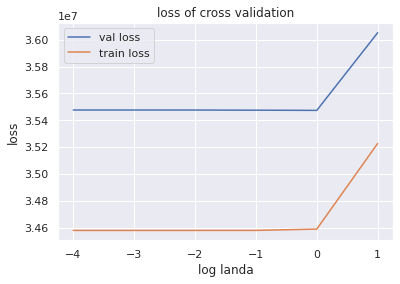

In [246]:
depths = range(1,9)
plt.plot(landas_power, loss_val_arr, label = 'val loss')
plt.plot(landas_power, loss_train_arr, label = 'train loss')
plt.xlabel('log landa')
plt.ylabel('loss')
plt.title('loss of cross validation')
plt.legend()
plt.show()

--> landa = 0

In [247]:
reg = Regressor(X_train, y_train)
w = reg.calculate_w(0)
reg.set_w(w)

In [248]:
print('loss train:', reg.loss(X_train,y_train,0))
print('loss test:', reg.loss(X_test, y_test, 0))

loss train: [5.51604705e+09]
loss test: [6.6428233e+09]
